# Don't Overfit! II EDA + ML

We have 20,000 rows of continuous variables, and a mere handful of training samples. Once again, we challenge you not to overfit. Do your best, model without overfitting, and add, perhaps, to your own legend.

In addition to bragging rights, the winner also gets swag. Enjoy!

![](https://www.apixio.com/wp-content/uploads/2017/10/classification-with-overfitting-2.png)
[image-source](https://www.apixio.com/wp-content/uploads/2017/10/classification-with-overfitting-2.png)

### Below is a personal train of thought on how to deal this problem and generally how to conduct a series of experiments

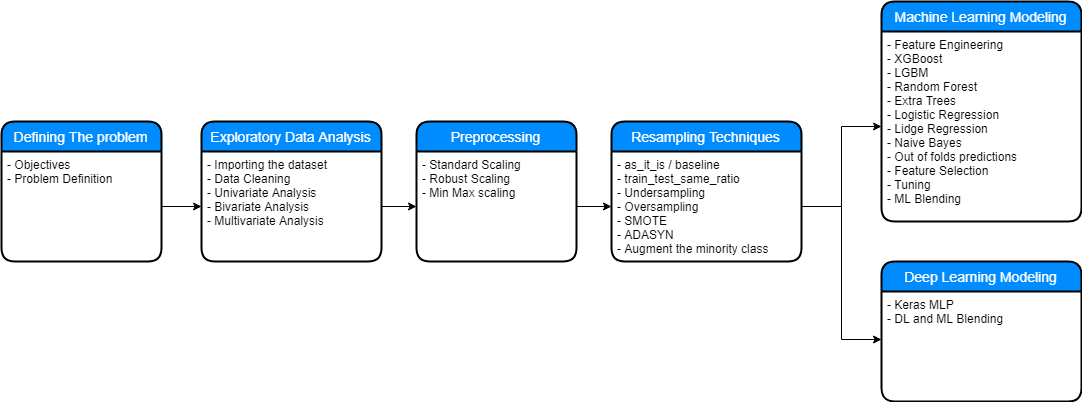

## Table of Contents
- Problem Definition and Objectives
- [Exploratory Data Analysis](#eda)
- Machine Learning Modeling
    - Potential Resampling Techniques
    - Feature Engineering
    - ML Modeling
    - Feature Selection
    - Tuning
    - DL Modeling
    - Ensemble / Blend Models
- Conclusion

### Experiment, Train of thought:

#### EDA -> Resampling (as it is) -> ML Modeling / DL Modeling

## Exploratory Data Analysis
<a id="eda"></a>

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')

import gc

# Any results you write to the current directory are saved as output.

### reading the data

In [ ]:
train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')

### the dataset size

In [ ]:
train.shape, test.shape

In [ ]:
train.columns

In [ ]:
train.target.value_counts()

In [ ]:
train.target.value_counts() / len(train)

In [ ]:
train['target'].value_counts().plot(kind="pie", figsize=(12,9), colormap="coolwarm")

### Checking for number of NULL values.

In [ ]:
train.isna().sum().sum()

In [ ]:
test.isna().sum().sum()

In [ ]:
train.describe()

Most of the features seems to be standardized / normalized.

In [ ]:
numerical_features = train.columns[2:]

In [ ]:
print('Distributions - Histograms columns')
plt.figure(figsize=(30, 200))
for i, col in enumerate(numerical_features):
    plt.subplot(50, 6, i + 1)
    plt.hist(train[col]) 
    plt.title(col)
gc.collect();

### Plotting all the distributions for all the features.

In [ ]:
print('Distributions columns')
plt.figure(figsize=(30, 200))
for i, col in enumerate(numerical_features):
    plt.subplot(50, 6, i + 1)
    plt.hist(train[train["target"] == 0][col], alpha=0.5, label='0', color='b')
    plt.hist(train[train["target"] == 1][col], alpha=0.5, label='1', color='r')    
    plt.title(col)
gc.collect();

### Plotting the mean, std, skewness and kurtosis for all the features

In [ ]:
plt.figure(figsize=(20, 8))
train[numerical_features].mean().plot('hist');
plt.title('Mean Frequency');

In [ ]:
plt.figure(figsize=(20, 8))
train[numerical_features].median().plot('hist');
plt.title('Median Frequency');

In [ ]:
plt.figure(figsize=(20, 8))
train[numerical_features].std().plot('hist');
plt.title('Standard Deviation Frequency');

In [ ]:
plt.figure(figsize=(20, 8))
train[numerical_features].skew().plot('hist');
plt.title('Skewness Frequency');

In [ ]:
plt.figure(figsize=(20, 8))
train[numerical_features].kurt().plot('hist');
plt.title('Kurtosis Frequency');

#### In general, all the features seems to be normalized / standardized based on their mean and std deviation values. Moreover based on the Kurtosis and Skewness most of the distributions seems to be like a normal distribution.

In [ ]:
sns.set(rc={'figure.figsize':(20,28)})

# Compute the correlation matrix
corr = train[train.columns[1:]].corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(corr, mask=mask, 
            #annot=True, 
            #fmt=".2f", 
            cmap='coolwarm')

### Most correlated features with the target

In [ ]:
s = corr.unstack().drop_duplicates()
so = s.sort_values(kind="quicksort")
so = so.drop_duplicates()

In [ ]:
s["target"].sort_values()[:10]

In [ ]:
s["target"].sort_values(ascending=False)[:10]

In [ ]:
print("Top most highly positive correlated features:")
print(so[(so<1) & (so>0.2)].sort_values(ascending=False))

print()

print("Top most highly megative correlated features:")
print(so[(so < - 0.2)])

#### In general there are no strong positive and negative correlations, only some upto +/- 0.3 pearson correlation.

## Machine Learning Modeling

In [ ]:
train.shape, test.shape

### Feature Engineering
Adding more features to the dataset.

In [ ]:
# special thanks to https://www.kaggle.com/gpreda/santander-eda-and-prediction
# also big help for feature engineering :https://www.kaggle.com/hjd810/keras-lgbm-aug-feature-eng-sampling-prediction
# last but not least: https://www.kaggle.com/c/santander-customer-transaction-prediction/discussion/87486#latest-506429

fs_params = dict()
fs_params["descriptives"] = False
fs_params["standardization"] = False
fs_params["percentiles"] = False
fs_params["squared"] = False
fs_params["frequency"] = False

gc.collect();
turn = 0
from sklearn.preprocessing import StandardScaler
for df in [test, train]:
    
    
    if turn == 0:
        print("Train set")
        turn = 1
    else:
        print("Test set")
    
    if (fs_params["descriptives"] == True):
        print('\t*descriptive statistics Feature Engineering:')
        df['sum'] = df[numerical_features].sum(axis=1)  
        df['min'] = df[numerical_features].min(axis=1)
        df['max'] = df[numerical_features].max(axis=1)
        df['mean'] = df[numerical_features].mean(axis=1)
        df['std'] = df[numerical_features].std(axis=1)
        df['skew'] = df[numerical_features].skew(axis=1)
        df['kurt'] = df[numerical_features].kurtosis(axis=1)
        df['med'] = df[numerical_features].median(axis=1)
        print('\t*descriptive statistics Feature Engineering done!')
    
    if (fs_params["standardization"] == True):
        print('\t*Standardizing the data:')
        #inf values can result from squaring
        scaler = StandardScaler()
        df[numerical_features] = scaler.fit_transform(df[numerical_features])
        print('\t*Data Standardized!')
    
    if (fs_params["percentiles"] == True):
        print('\t*percentiles Feature Engineering:')
        perc_list = [1,2,5,10,25,50,60,75,80,85,95,99]
        for i in perc_list:
            df['perc_'+str(i)] =  df[numerical_features].apply(lambda x: np.percentile(x, i), axis=1)
        print('\t*Done percentiles Feature Engineering!')
    
    if (fs_params["squared"] == True):
        print('\t*Loading Squared data:')
        for i in numerical_features:
            df['var_sq_'+str(i)] = np.square(df[str(i)])
        print('\t*Done squaring!')
    
    if (fs_params["frequency"] == True):
        #thanks to  https://www.kaggle.com/c/santander-customer-transaction-prediction/discussion/87486#latest-506429
        print('\t*Loading frequency:')
        for var in numerical_features:
            hist, bin_edges = np.histogram(df[var], bins=1000, density=True)
            df['hist_'+var] = [ hist[np.searchsorted(bin_edges,ele)-1] for ele in df[var]]
        print('\t*Done Loading frequency!')
    
gc.collect();

In [ ]:
train.columns

In [ ]:
train.head(6)

In [ ]:
train.shape, test.shape

## Pre-processing
Should I scale the features.

In [ ]:
y = train['target']
X = train.drop(['target', "id"], axis=1)
xtest = test.drop("id", axis="columns")

std_scaler_flag = False
robust_scaler_flag = False
min_max_scalar_flag = False

if std_scaler_flag == True:

    print("StandardScaler!")
    from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler

    sc0 = StandardScaler()
    sc0.fit(X)
    X = sc0.transform(X)
    X = pd.DataFrame(X, columns=train.drop(['target', "id"], axis=1).columns)
    xtest = sc0.transform(xtest)
    xtest = pd.DataFrame(xtest, columns = test.drop("id", axis="columns").columns)
    print(X.head(6))

else:
    print("No scaling at all!")

In [ ]:
clf_stats_df = pd.DataFrame(columns=["clf_name", "F1-score", "auc-score"])

### XGBoost
<a id="base"></a>
I will use XGBoost as my ML model, 

In [ ]:
def xgboost_all_purpose(X, y, type_of_training, name, num_of_folds=3, params=None, in_folds_sampling = False, max_early_stopping = 100):
    
    ####
    #
    # This is an all purpose xgboost function for all balanced, imbalanced and resampling cases
    # please excuse me for its length
    # The different types of training that the method supports are the following:
    #
    # baseline
    # train_test_equal
    # smote
    # oversampling
    # adasyn
    # 
    #
    ####
    
    
    from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
    from collections import Counter
    from sklearn.metrics import accuracy_score
    from sklearn.metrics import precision_score
    from sklearn.metrics import recall_score
    from sklearn.metrics import f1_score
    from sklearn.metrics import classification_report
    from sklearn.metrics import roc_auc_score
    import scikitplot as skplt
    import time
    import random
    
    import xgboost as xgb
    
    global clf_stats_df
    
    if params is None:
        params = dict()
        params["learning_rate"] = 0.1
        params["n_estimators"] = 500
        params["max_depth"] = 3
        params["min_child_weight"] = 1
        params["gamma"] = 0
        params["subsample"] = 1
        params["colsample_bytree"] = 1
        params["colsample_bylevel"] = 1
        params["reg_alpha"] = 0
        params["reg_lambda"] = 1
        params["scale_pos_weight"] = np.round(y.value_counts()[0] / y.value_counts()[1],3)
        #params["scale_pos_weight"] = 1
        #params["max_delta_step"] = 0
        params["max_delta_step"] = 1
    
    print("params", params)
    print("max_early_stopping:", max_early_stopping)
    
    if type_of_training == "baseline":
        
        print("baseline")
        
        # create a 70/30 stratified split of the data 
        xtrain, xvalid, ytrain, yvalid = train_test_split(X, y, stratify = y, random_state=42, test_size=0.3)
    
        import xgboost as xgb

        start_time = time.time()
        
        predictions_probas_list = np.zeros([len(yvalid), 2])
        predictions_test = np.zeros(len(test))
        num_fold = 0
        #feature_importance_df = pd.DataFrame()
        
        folds = StratifiedKFold(n_splits=num_of_folds, shuffle=False, random_state = 42)
        
        for train_index, valid_index in folds.split(xtrain, ytrain):
            xtrain_stra, xvalid_stra = xtrain.iloc[train_index,:], xtrain.iloc[valid_index,:]
            ytrain_stra, yvalid_stra = ytrain.iloc[train_index], ytrain.iloc[valid_index]
            
            print()
            print("Stratified Fold:", num_fold)
            num_fold = num_fold + 1
            print()
            
            clf_stra_xgb = xgb.XGBClassifier(learning_rate=params["learning_rate"], 
                                    n_estimators=params["n_estimators"], 
                                    max_depth=params["max_depth"],
                                    min_child_weight=params["min_child_weight"],
                                    gamma=params["gamma"],
                                    subsample=params["subsample"],
                                    colsample_bytree=params["colsample_bytree"],
                                    colsample_bylevel=params["colsample_bylevel"],
                                    objective= 'binary:logistic',
                                    nthread=-1,
                                    scale_pos_weight=params["scale_pos_weight"],
                                    reg_alpha = params["reg_alpha"],
                                    reg_lambda = params["reg_lambda"],
                                    max_delta_step = params["max_delta_step"],
                                    seed=42)

            clf_stra_xgb.fit(xtrain_stra, ytrain_stra, eval_set=[(xtrain_stra, ytrain_stra), (xvalid_stra, yvalid_stra)], 
                        early_stopping_rounds=max_early_stopping, eval_metric='auc', verbose=100)
            
            #fold_importance_df = pd.DataFrame()
            #fold_importance_df["feature"] = pd.DataFrame.from_dict(data=clf_stra_xgb.get_fscore(), orient="index", columns=["FScore"])["FScore"].index
            #fold_importance_df["fscore"] = pd.DataFrame.from_dict(data=clf_stra_xgb.get_fscore(), orient="index", columns=["FScore"])["FScore"].values
            #fold_importance_df["fold"] = n_fold + 1
            #feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

            predictions = clf_stra_xgb.predict(xvalid)
            predictions_probas = clf_stra_xgb.predict_proba(xvalid)
            predictions_probas_list += predictions_probas/num_of_folds
            
            predictions_test += clf_stra_xgb.predict_proba(test[xtrain.columns])[:,1]/num_of_folds
            
        
        predictions = np.argmax(predictions_probas, axis=1)

        print()
        print(classification_report(yvalid, predictions))

        print()
        print("CV f1_score", f1_score(yvalid, predictions, average = "macro"))
        
        print()
        print("CV roc_auc_score", roc_auc_score(yvalid, predictions_probas_list[:,1], average = "macro"))
        
        print()
        print("elapsed time in seconds: ", time.time() - start_time)
        
        sns.set(rc={'figure.figsize':(8,8)})
        skplt.metrics.plot_confusion_matrix(yvalid, predictions, normalize=True)
        
        sns.set(rc={'figure.figsize':(8,8)})
        skplt.metrics.plot_roc(yvalid, predictions_probas)
        
        sns.set(rc={'figure.figsize':(8,8)})
        skplt.metrics.plot_ks_statistic(yvalid, predictions_probas)
        
        sns.set(rc={'figure.figsize':(8,8)})
        skplt.metrics.plot_precision_recall(yvalid, predictions_probas)
        
        sns.set(rc={'figure.figsize':(8,8)})
        skplt.metrics.plot_cumulative_gain(yvalid, predictions_probas)

        sns.set(rc={'figure.figsize':(8,8)})
        skplt.metrics.plot_lift_curve(yvalid, predictions_probas)
        
        sns.set(rc={'figure.figsize':(12, 38)})
        xgb.plot_importance(clf_stra_xgb, title='Feature importance', xlabel='F score', ylabel='Features')

        clf_stats_df = clf_stats_df.append({"clf_name": name,
                             "F1-score":f1_score(yvalid, predictions, average = "macro"),
                             "auc-score": roc_auc_score(yvalid, predictions_probas_list[:,1], average = "macro")}, ignore_index=True)
        
        print()
        gc.collect();
        return clf_stra_xgb, predictions_test
    
    elif type_of_training == "train_test_equal":
        
        print("train_test_equal_flag")
        
        # create a 70/30 stratified split of the data 
        xtrain, xvalid, ytrain, yvalid = train_test_split(X, y, stratify = y, random_state=42, test_size=0.3)
    
        import xgboost as xgb

        start_time = time.time()
        
        predictions_probas_list = np.zeros([len(yvalid), 2])
        predictions_test = np.zeros(len(test))
        num_fold = 0
        #feature_importance_df = pd.DataFrame()
        
        print("resample xtrain set to be equal to the size of the test set")
        temp_df = pd.DataFrame(xtrain, columns=xtrain.columns)
        temp_df["target"] = ytrain
        temp_df = temp_df.sample(frac = len(test) / len(xtrain), replace = True)
        ytrain = temp_df['target']
        xtrain = temp_df.drop(['target'], axis=1)
        del temp_df;
        print(xtrain.shape, test.shape)
        
        folds = StratifiedKFold(n_splits=num_of_folds, shuffle=False, random_state = 42)
        
        for train_index, valid_index in folds.split(xtrain, ytrain):
            xtrain_stra, xvalid_stra = xtrain.iloc[train_index,:], xtrain.iloc[valid_index,:]
            ytrain_stra, yvalid_stra = ytrain.iloc[train_index], ytrain.iloc[valid_index]
            
            print()
            print("Stratified Fold:", num_fold)
            num_fold = num_fold + 1
            print()
            
            clf_stra_xgb = xgb.XGBClassifier(learning_rate=params["learning_rate"], 
                                    n_estimators=params["n_estimators"], 
                                    max_depth=params["max_depth"],
                                    min_child_weight=params["min_child_weight"],
                                    gamma=params["gamma"],
                                    subsample=params["subsample"],
                                    colsample_bytree=params["colsample_bytree"],
                                    colsample_bylevel=params["colsample_bylevel"],
                                    objective= 'binary:logistic',
                                    nthread=-1,
                                    scale_pos_weight=params["scale_pos_weight"],
                                    reg_alpha = params["reg_alpha"],
                                    reg_lambda = params["reg_lambda"],
                                    max_delta_step = params["max_delta_step"],
                                    seed=42)

            clf_stra_xgb.fit(xtrain_stra, ytrain_stra, eval_set=[(xtrain_stra, ytrain_stra), (xvalid_stra, yvalid_stra)], 
                        early_stopping_rounds=max_early_stopping, eval_metric='auc', verbose=100)
            
            #fold_importance_df = pd.DataFrame()
            #fold_importance_df["feature"] = pd.DataFrame.from_dict(data=clf_stra_xgb.get_fscore(), orient="index", columns=["FScore"])["FScore"].index
            #fold_importance_df["fscore"] = pd.DataFrame.from_dict(data=clf_stra_xgb.get_fscore(), orient="index", columns=["FScore"])["FScore"].values
            #fold_importance_df["fold"] = n_fold + 1
            #feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

            predictions = clf_stra_xgb.predict(xvalid)
            predictions_probas = clf_stra_xgb.predict_proba(xvalid)
            predictions_probas_list += predictions_probas/num_of_folds
            
            predictions_test += clf_stra_xgb.predict_proba(test[xtrain.columns])[:,1]/num_of_folds
            
        
        predictions = np.argmax(predictions_probas, axis=1)

        print()
        print(classification_report(yvalid, predictions))

        print()
        print("CV f1_score", f1_score(yvalid, predictions, average = "macro"))
        
        print()
        print("CV roc_auc_score", roc_auc_score(yvalid, predictions_probas_list[:,1], average = "macro"))
        
        print()
        print("elapsed time in seconds: ", time.time() - start_time)
        
        sns.set(rc={'figure.figsize':(8,8)})
        skplt.metrics.plot_confusion_matrix(yvalid, predictions, normalize=True)
        
        sns.set(rc={'figure.figsize':(8,8)})
        skplt.metrics.plot_roc(yvalid, predictions_probas)
        
        sns.set(rc={'figure.figsize':(8,8)})
        skplt.metrics.plot_ks_statistic(yvalid, predictions_probas)
        
        sns.set(rc={'figure.figsize':(8,8)})
        skplt.metrics.plot_precision_recall(yvalid, predictions_probas)
        
        sns.set(rc={'figure.figsize':(8,8)})
        skplt.metrics.plot_cumulative_gain(yvalid, predictions_probas)

        sns.set(rc={'figure.figsize':(8,8)})
        skplt.metrics.plot_lift_curve(yvalid, predictions_probas)
        
        sns.set(rc={'figure.figsize':(12, 38)})
        xgb.plot_importance(clf_stra_xgb, title='Feature importance', xlabel='F score', ylabel='Features')

        clf_stats_df = clf_stats_df.append({"clf_name": name,
                             "F1-score":f1_score(yvalid, predictions, average = "macro"),
                             "auc-score": roc_auc_score(yvalid, predictions_probas_list[:,1], average = "macro")}, ignore_index=True)
        
        print()
        gc.collect();
        return clf_stra_xgb, predictions_test

    
    
    else:
        print("Please specify for the argument 'type_of_training'one of the following parameters: (baseline, oversampling, smote, undersampling, augmentation_by_fraction)")

In [ ]:
type_of_training = "baseline"
    
num_of_folds = 4 ### must be more than 2
in_folds_sampling = False

clf_xgb, predictions_test_xgb = xgboost_all_purpose(X,y, num_of_folds = num_of_folds, 
                                                    type_of_training =type_of_training, 
                                                    in_folds_sampling = in_folds_sampling, 
                                                    max_early_stopping = 200, 
                                                    name="clf_xgb")

del clf_xgb

### Feature Selection
<a id="fs"></a>

In [ ]:
gc.collect()
import eli5
feature_selection_flag = True

if feature_selection_flag == True:
    from sklearn.model_selection import train_test_split
    from sklearn.ensemble import RandomForestClassifier
    import xgboost as xgb

    gc.collect();
    xtrain, xvalid, ytrain, yvalid = train_test_split(X, y, stratify = y, test_size=0.3, random_state=42)


    #rfc_model = RandomForestClassifier(random_state=42, 
    #                                   class_weight={0: 1, 1: np.round(y.value_counts()[0] / y.value_counts()[1],3)}
    #                                  )
    
    fs_model = xgb.XGBClassifier(nthread = -1, 
                                  objective = 'binary:logistic', 
                                  eval_metric = 'auc', 
                                  silent=1, 
                                  tree_method='auto',
                                  max_depth = 3,  
                                  scale_pos_weight = np.round(y.value_counts()[0] / y.value_counts()[1],3))
    
    fs_model.fit(xtrain, ytrain)

    import eli5
    from eli5.sklearn import PermutationImportance

    perm = PermutationImportance(fs_model, random_state=42).fit(xvalid, yvalid)

In [ ]:
eli5.show_weights(perm, feature_names = xvalid.columns.tolist(), top=100)

In [ ]:
if feature_selection_flag == True:
    from sklearn.feature_selection import SelectFromModel
   
    max_selected_features = 50
    sel = SelectFromModel(perm, max_features = max_selected_features, prefit=True)

    feature_idx = sel.get_support()
    selected_feature_names = X.columns[feature_idx]

    
    X_fs_50 = X[selected_feature_names]
    print(X_fs_50.shape)
    
    max_selected_features = 25
    sel = SelectFromModel(perm, max_features = max_selected_features, prefit=True)

    feature_idx = sel.get_support()
    selected_feature_names = X.columns[feature_idx]

    
    X_fs_25 = X[selected_feature_names]
    print(X_fs_25.shape)
    
    max_selected_features = 15
    sel = SelectFromModel(perm, max_features = max_selected_features, prefit=True)

    feature_idx = sel.get_support()
    selected_feature_names = X.columns[feature_idx]

    
    X_fs_15 = X[selected_feature_names]
    print(X_fs_15.shape)

In [ ]:
   fs_clf_xgb, predictions_test_fs_50_xgb = xgboost_all_purpose(X_fs_50,
                                                              y,
                                                              type_of_training =type_of_training, 
                                                              num_of_folds = num_of_folds, 
                                                              max_early_stopping= 100, 
                                                              name="fs_clf_50_xgb")

In [ ]:
    fs_clf_xgb, predictions_test_fs_25_xgb = xgboost_all_purpose(X_fs_25,
                                                              y,
                                                              type_of_training =type_of_training, 
                                                              num_of_folds = num_of_folds, 
                                                              max_early_stopping= 100, 
                                                              name="fs_clf_25_xgb")

In [ ]:
   fs_clf_xgb, predictions_test_fs_15_xgb = xgboost_all_purpose(X_fs_15,
                                                              y,
                                                              type_of_training =type_of_training, 
                                                              num_of_folds = num_of_folds, 
                                                              max_early_stopping= 100, 
                                                              name="fs_clf_15_xgb")

In [ ]:
clf_stats_df

### ML Bayesian Tuning

In [ ]:
as_it_is = True
smote_flag = False
adasyn_flag = False
oversampling_flag = False
augment_flag = False

def prepare_for_tuning(X, y, type_of_training):
    
    from sklearn.model_selection import train_test_split

    if type_of_training == "baseline":

        print("no resampling at all!")
        from sklearn.model_selection import train_test_split
        xtrain, xvalid, ytrain, yvalid = train_test_split(X, y, stratify = y, random_state=42, test_size=0.3)

    elif type_of_training == "train_test_equal":

            print("train_test_equal")

            # create a 70/30 stratified split of the data 
            xtrain, xvalid, ytrain, yvalid = train_test_split(X, y, stratify = y, random_state=42, test_size=0.3)

            print("resample xtrain set to be equal to the size of the test set")
            temp_df = pd.DataFrame(xtrain, columns=xtrain.columns)
            temp_df["target"] = ytrain
            temp_df = temp_df.sample(frac = len(test) / len(xtrain), replace = True)
            ytrain = temp_df['target']
            xtrain = temp_df.drop(['target'], axis=1)
            del temp_df;
            print(xtrain.shape, test.shape)



    elif type_of_training == "oversampling":

        print("oversampling")

        from imblearn.over_sampling import SMOTE, ADASYN, RandomOverSampler

        # create a 70/30 split of the data 
        xtrain, xvalid, ytrain, yvalid = train_test_split(X, y, stratify = y, random_state=42, test_size=0.3)

        # RandomOverSampler
        ros = RandomOverSampler(random_state=42)
        X_resampled, y_resampled = ros.fit_resample(xtrain, ytrain)

        from collections import Counter
        print(sorted(Counter(y_resampled).items()))

        xtrain=pd.DataFrame(X_resampled, columns = X.columns)
        ytrain = y_resampled
        del X_resampled
        del y_resampled


    elif type_of_training == "augmentation_by_fraction":

        from sklearn.model_selection import train_test_split
        # the main idea here is to reducing the imbalance ratio from 9:1 to 3:1
        print("augmentation")

        from collections import Counter

        # create a 70/30 split of the data 
        xtrain, xvalid, ytrain, yvalid = train_test_split(X, y, stratify = y, random_state=42, test_size=0.3)

        print("ytrain target values count before augmentation:\n", sorted(Counter(ytrain).items()))

        # Augmenting both minority and majority classes via RandomOverSampler by 3 times
        X_y = pd.DataFrame(xtrain, columns=X.columns)
        X_y["target"] = ytrain
        X_y = X_y.sample(frac=3, replace=True)
        X_y.target.value_counts()
        ytrain = X_y['target']
        print("ytrain target values count after oversampling:\n",sorted(Counter(ytrain).items()))
        xtrain = X_y.drop(['target'], axis=1)
        del X_y

        from imblearn.under_sampling import RandomUnderSampler

        # reducing the majority class almost back to its original form
        rus = RandomUnderSampler(sampling_strategy=0.33, random_state=42)
        X_resampled, y_resampled = rus.fit_resample(xtrain, ytrain)

        print("ytrain target values count after Augmentation:\n",sorted(Counter(y_resampled).items()))

        xtrain=pd.DataFrame(X_resampled, columns = X.columns)
        ytrain = y_resampled

        del X_resampled
        del y_resampled
        gc.collect();
        
    return xtrain, ytrain

### Bayesian Tuning with all the features

In [ ]:
def bayesian_tuning(xtrain, ytrain):
    
    from skopt import BayesSearchCV
    from sklearn.model_selection import StratifiedKFold
    import xgboost as xgb

    # Classifier
    bayes_cv_tuner = BayesSearchCV(
        estimator = xgb.XGBClassifier(
            nthread = -1,
            objective = 'binary:logistic',
            eval_metric = 'auc',
            silent=1,
            tree_method='auto'
        ),
        search_spaces = {
            'learning_rate': (0.01, 1.0, 'log-uniform'),
            'min_child_weight': (0, 10),
            'n_estimators': (50, 100),
            'max_depth': (0, 12),
            'gamma': (1e-2, 10, 'log-uniform'),
            'subsample': (0.01, 1.0, 'uniform'),
            'colsample_bytree': (0.01, 1.0, 'uniform'),
            'colsample_bylevel': (0.01, 1.0, 'uniform'),
            'scale_pos_weight': (0.01, 1.0, 'uniform'),
            'reg_lambda': (1e-1, 10, 'log-uniform'),
            'reg_alpha': (1e-2, 1.0, 'log-uniform'),
            'max_delta_step': (0, 10, 'uniform'),
            'scale_pos_weight': (1e-2, 1, 'uniform')
        },    
        scoring = 'roc_auc',
        cv = StratifiedKFold(
            n_splits=3,
            shuffle=True,
            random_state=42
        ),
        n_jobs = 1,
        n_iter = 7,   
        verbose = 0,
        refit = True,
        random_state = 42
    )

    def status_print(optim_result):
        """Status callback durring bayesian hyperparameter search"""

        # Get all the models tested so far in DataFrame format
        all_models = pd.DataFrame(bayes_cv_tuner.cv_results_)    

        # Get current parameters and the best parameters    
        best_params = pd.Series(bayes_cv_tuner.best_params_)
        print('Model #{}\nBest ROC-AUC: {}\nBest params: {}\n'.format(
            len(all_models),
            np.round(bayes_cv_tuner.best_score_, 4),
            bayes_cv_tuner.best_params_
        ))

        ### Save all model results
        #clf_name = bayes_cv_tuner.estimator.__class__.__name__
        #all_models.to_csv(clf_name+"_cv_results.csv")
        ###
        
    result = bayes_cv_tuner.fit(xtrain, ytrain, callback = status_print)
    return result
    
# Fit the model
xtrain, ytrain = prepare_for_tuning(X, y, type_of_training=type_of_training)
result = bayesian_tuning(xtrain, ytrain)

### Tuned XGBoost training with all the features

In [ ]:
gc.collect()

result.best_params_['n_estimators'] = 3000

num_of_folds = 4 ### must be more than 2

tuned_clf_xgb, predictions_test_tuned_xgb = xgboost_all_purpose(X,
                                                                y,
                                                                type_of_training = type_of_training, 
                                                                num_of_folds=num_of_folds, 
                                                                params = result.best_params_, 
                                                                max_early_stopping = 200, 
                                                                in_folds_sampling = False,
                                                                name="tuned_clf_xgb")

In [ ]:
clf_stats_df

### Bayesian Tuning with 50 features

In [ ]:
xtrain, ytrain = prepare_for_tuning(X_fs_50, y, type_of_training=type_of_training)
result = bayesian_tuning(xtrain, ytrain)

### Tuned XGBoost training with top 50 features

In [ ]:
gc.collect()

result.best_params_['n_estimators'] = 3000

num_of_folds = 4 ### must be more than 2

tuned_clf_fs_50_xgb, predictions_test_tuned_fs_50_xgb = xgboost_all_purpose(X_fs_50,
                                                                y,
                                                                type_of_training = type_of_training, 
                                                                num_of_folds=num_of_folds, 
                                                                params = result.best_params_, 
                                                                max_early_stopping = 200, 
                                                                in_folds_sampling = False,
                                                                name="tuned_clf_fs_50_xgb")

In [ ]:
clf_stats_df

### Bayesian Tuning with 25 features

In [ ]:
xtrain, ytrain = prepare_for_tuning(X_fs_25, y, type_of_training=type_of_training)
result = bayesian_tuning(xtrain, ytrain)

### Tuned XGBoost training with top 25 features

In [ ]:
gc.collect()

result.best_params_['n_estimators'] = 3000

num_of_folds = 4 ### must be more than 2

tuned_clf_fs_25_xgb, predictions_test_tuned_fs_25_xgb = xgboost_all_purpose(X_fs_25,
                                                                y,
                                                                type_of_training = type_of_training, 
                                                                num_of_folds=num_of_folds, 
                                                                params = result.best_params_, 
                                                                max_early_stopping = 200, 
                                                                in_folds_sampling = False,
                                                                name="tuned_clf_fs_25_xgb")

In [ ]:
clf_stats_df

### Bayesian Tuning with 15 features

In [ ]:
xtrain, ytrain = prepare_for_tuning(X_fs_15, y, type_of_training=type_of_training)
result = bayesian_tuning(xtrain, ytrain)

### Tuned XGBoost training with top 15 features

In [ ]:
gc.collect()

result.best_params_['n_estimators'] = 3000

num_of_folds = 4 ### must be more than 2

tuned_clf_fs_15_xgb, predictions_test_tuned_fs_15_xgb = xgboost_all_purpose(X_fs_15,
                                                                y,
                                                                type_of_training = type_of_training, 
                                                                num_of_folds=num_of_folds, 
                                                                params = result.best_params_, 
                                                                max_early_stopping = 200, 
                                                                in_folds_sampling = False,
                                                                name="tuned_clf_fs_15_xgb")

In [ ]:
clf_stats_df

 ## Preparing Submissions

In [ ]:
gc.collect();
submission = pd.read_csv('../input/sample_submission.csv')
submission['target'] = predictions_test_xgb
submission.to_csv('clf_xgb.csv', index=False)


if feature_selection_flag == True:
    
    gc.collect();
    submission = pd.read_csv('../input/sample_submission.csv')
    submission['target'] = predictions_test_fs_50_xgb
    submission.to_csv('fs_50_clf_xgb.csv', index=False)
    
    gc.collect();
    submission = pd.read_csv('../input/sample_submission.csv')
    submission['target'] = predictions_test_fs_25_xgb
    submission.to_csv('fs_25_clf_xgb.csv', index=False)
    
    gc.collect();
    submission = pd.read_csv('../input/sample_submission.csv')
    submission['target'] = predictions_test_fs_15_xgb
    submission.to_csv('fs_15_clf_xgb.csv', index=False)


gc.collect();
submission = pd.read_csv('../input/sample_submission.csv')
submission['target'] = predictions_test_tuned_xgb
submission.to_csv('tuned_clf_xgb.csv', index=False)

gc.collect();
submission = pd.read_csv('../input/sample_submission.csv')
submission['target'] = predictions_test_tuned_fs_50_xgb
submission.to_csv('tuned_clf_fs_50_xgb.csv', index=False)

gc.collect();
submission = pd.read_csv('../input/sample_submission.csv')
submission['target'] = predictions_test_tuned_fs_25_xgb
submission.to_csv('tuned_clf_fs_25_xgb.csv', index=False)

gc.collect();
submission = pd.read_csv('../input/sample_submission.csv')
submission['target'] = predictions_test_tuned_fs_15_xgb
submission.to_csv('tuned_clf_fs_15_xgb.csv', index=False)

### Logistic Regression

In [ ]:
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold, RepeatedStratifiedKFold
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
import scikitplot as skplt
import time
import random

from sklearn.linear_model import LogisticRegression, Lasso



#print("baseline")

# create a 70/30 stratified split of the data 
xtrain, xvalid, ytrain, yvalid = train_test_split(X, y, stratify = y, random_state=42, test_size=0.1)

import xgboost as xgb

start_time = time.time()

predictions_probas_list = np.zeros([len(yvalid), 2])
predictions_test = np.zeros(len(test))
num_fold = 0
num_of_folds = 10
#feature_importance_df = pd.DataFrame()

folds = StratifiedKFold(n_splits=10, shuffle=False, random_state = 42)

for train_index, valid_index in folds.split(xtrain, ytrain):
    xtrain_stra, xvalid_stra = xtrain.iloc[train_index,:], xtrain.iloc[valid_index,:]
    ytrain_stra, yvalid_stra = ytrain.iloc[train_index], ytrain.iloc[valid_index]

    print()
    print("Stratified Fold:", num_fold)
    num_fold = num_fold + 1
    print()

    #fold_importance_df = pd.DataFrame()
    #fold_importance_df["feature"] = pd.DataFrame.from_dict(data=clf_stra_xgb.get_fscore(), orient="index", columns=["FScore"])["FScore"].index
    #fold_importance_df["fscore"] = pd.DataFrame.from_dict(data=clf_stra_xgb.get_fscore(), orient="index", columns=["FScore"])["FScore"].values
    #fold_importance_df["fold"] = n_fold + 1
    #feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    clf_logit = LogisticRegression(random_state=42,
                                   C=0.1,
                                   solver='liblinear',
                                   class_weight ="balanced",
                                   penalty = 'l1',
                                   multi_class='ovr').fit(xtrain_stra, ytrain_stra)

    predictions = clf_logit.predict(xvalid)
    predictions_probas = clf_logit.predict_proba(xvalid)
    predictions_probas_list += predictions_probas/num_of_folds

    predictions_test += clf_logit.predict_proba(test[xtrain.columns])[:,1]/num_of_folds


predictions = np.argmax(predictions_probas, axis=1)

print()
print(classification_report(yvalid, predictions))

print()
print("CV f1_score", f1_score(yvalid, predictions, average = "macro"))

print()
print("CV roc_auc_score", roc_auc_score(yvalid, predictions_probas_list[:,1], average = "macro"))

print()
print("elapsed time in seconds: ", time.time() - start_time)

sns.set(rc={'figure.figsize':(8,8)})
skplt.metrics.plot_confusion_matrix(yvalid, predictions, normalize=True)

sns.set(rc={'figure.figsize':(8,8)})
skplt.metrics.plot_roc(yvalid, predictions_probas)

sns.set(rc={'figure.figsize':(8,8)})
skplt.metrics.plot_ks_statistic(yvalid, predictions_probas)

sns.set(rc={'figure.figsize':(8,8)})
skplt.metrics.plot_precision_recall(yvalid, predictions_probas)

sns.set(rc={'figure.figsize':(8,8)})
skplt.metrics.plot_cumulative_gain(yvalid, predictions_probas)

sns.set(rc={'figure.figsize':(8,8)})
skplt.metrics.plot_lift_curve(yvalid, predictions_probas)

clf_stats_df = clf_stats_df.append({"clf_name": "clf_logit",
                     "F1-score":f1_score(yvalid, predictions, average = "macro"),
                     "auc-score": roc_auc_score(yvalid, predictions_probas_list[:,1], average = "macro")}, ignore_index=True)

print()

In [ ]:
clf_stats_df

### Recursive Feature Elimination for Feature Selection

In [ ]:
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold, RepeatedStratifiedKFold
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
import scikitplot as skplt
import time
import random
from sklearn.feature_selection import RFE

from sklearn.linear_model import LogisticRegression, Lasso



#print("baseline")

# create a 70/30 stratified split of the data 
xtrain, xvalid, ytrain, yvalid = train_test_split(X, y, stratify = y, random_state=42, test_size=0.1)

import xgboost as xgb

start_time = time.time()

predictions_probas_list = np.zeros([len(yvalid), 2])
predictions_test_rfe = np.zeros(len(test))
num_fold = 0
num_of_folds = 10
#feature_importance_df = pd.DataFrame()

folds = StratifiedKFold(n_splits=10, shuffle=False, random_state = 42)

for train_index, valid_index in folds.split(xtrain, ytrain):
    xtrain_stra, xvalid_stra = xtrain.iloc[train_index,:], xtrain.iloc[valid_index,:]
    ytrain_stra, yvalid_stra = ytrain.iloc[train_index], ytrain.iloc[valid_index]

    print()
    print("Stratified Fold:", num_fold)
    num_fold = num_fold + 1
    print()

    #fold_importance_df = pd.DataFrame()
    #fold_importance_df["feature"] = pd.DataFrame.from_dict(data=clf_stra_xgb.get_fscore(), orient="index", columns=["FScore"])["FScore"].index
    #fold_importance_df["fscore"] = pd.DataFrame.from_dict(data=clf_stra_xgb.get_fscore(), orient="index", columns=["FScore"])["FScore"].values
    #fold_importance_df["fold"] = n_fold + 1
    #feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    clf_logit = LogisticRegression(random_state=42,
                                   C=0.1,
                                   solver='liblinear',
                                   class_weight ="balanced",
                                   penalty = 'l1',
                                   multi_class='ovr')
    
    #clf_logit.fit(xtrain_stra, ytrain_stra)
    
    selector = RFE(clf_logit, 21)
    selector.fit(xtrain_stra, ytrain_stra)
    
    clf_logit_rfe = selector

    predictions = clf_logit_rfe.predict(xvalid)
    predictions_probas = clf_logit_rfe.predict_proba(xvalid)
    predictions_probas_list += predictions_probas/num_of_folds

    predictions_test_rfe += clf_logit_rfe.predict_proba(test[xtrain.columns])[:,1]/num_of_folds


predictions = np.argmax(predictions_probas, axis=1)

print()
print(classification_report(yvalid, predictions))

print()
print("CV f1_score", f1_score(yvalid, predictions, average = "macro"))

print()
print("CV roc_auc_score", roc_auc_score(yvalid, predictions_probas_list[:,1], average = "macro"))

print()
print("elapsed time in seconds: ", time.time() - start_time)

sns.set(rc={'figure.figsize':(8,8)})
skplt.metrics.plot_confusion_matrix(yvalid, predictions, normalize=True)

sns.set(rc={'figure.figsize':(8,8)})
skplt.metrics.plot_roc(yvalid, predictions_probas)

sns.set(rc={'figure.figsize':(8,8)})
skplt.metrics.plot_ks_statistic(yvalid, predictions_probas)

sns.set(rc={'figure.figsize':(8,8)})
skplt.metrics.plot_precision_recall(yvalid, predictions_probas)

sns.set(rc={'figure.figsize':(8,8)})
skplt.metrics.plot_cumulative_gain(yvalid, predictions_probas)

sns.set(rc={'figure.figsize':(8,8)})
skplt.metrics.plot_lift_curve(yvalid, predictions_probas)

clf_stats_df = clf_stats_df.append({"clf_name": "clf_logit",
                     "F1-score":f1_score(yvalid, predictions, average = "macro"),
                     "auc-score": roc_auc_score(yvalid, predictions_probas_list[:,1], average = "macro")}, ignore_index=True)

print()

### Soft Voting Classifier

In [ ]:
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold, RepeatedStratifiedKFold
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
import scikitplot as skplt
import time
import random
from sklearn.feature_selection import RFE
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import VotingClassifier,BaggingClassifier, ExtraTreesClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.linear_model import LogisticRegression, Lasso



#print("baseline")

# create a 70/30 stratified split of the data 
xtrain, xvalid, ytrain, yvalid = train_test_split(X, y, stratify = y, random_state=42, test_size=0.1)

import xgboost as xgb

start_time = time.time()

predictions_probas_list = np.zeros([len(yvalid), 2])
predictions_test_voting = np.zeros(len(test))
num_fold = 0
num_of_folds = 10
#feature_importance_df = pd.DataFrame()

folds = StratifiedKFold(n_splits=10, shuffle=False, random_state = 42)

for train_index, valid_index in folds.split(xtrain, ytrain):
    xtrain_stra, xvalid_stra = xtrain.iloc[train_index,:], xtrain.iloc[valid_index,:]
    ytrain_stra, yvalid_stra = ytrain.iloc[train_index], ytrain.iloc[valid_index]

    print()
    print("Stratified Fold:", num_fold)
    num_fold = num_fold + 1
    print()

    #fold_importance_df = pd.DataFrame()
    #fold_importance_df["feature"] = pd.DataFrame.from_dict(data=clf_stra_xgb.get_fscore(), orient="index", columns=["FScore"])["FScore"].index
    #fold_importance_df["fscore"] = pd.DataFrame.from_dict(data=clf_stra_xgb.get_fscore(), orient="index", columns=["FScore"])["FScore"].values
    #fold_importance_df["fold"] = n_fold + 1
    #feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    log_clf = LogisticRegression(C = 0.1, class_weight= 'balanced', penalty= 'l1', solver= 'liblinear',random_state=42)
    rand_clf = RandomForestClassifier(max_depth=2,random_state=42)
    svm_clf = SVC(gamma='auto',probability=True, random_state=42)
    extra_clf = ExtraTreesClassifier(max_depth=2,random_state=42)
    #ada_clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1), n_estimators=200,algorithm='SAMME.R', learning_rate=0.5, random_state=42)

    voting_clf = VotingClassifier(
        estimators = [('lr',log_clf),('rf',rand_clf),('ex',extra_clf),('sv',svm_clf)],
        voting='soft')
    
    voting_clf.fit(xtrain_stra, ytrain_stra)

    predictions = voting_clf.predict(xvalid)
    predictions_probas = voting_clf.predict_proba(xvalid)
    predictions_probas_list += predictions_probas/num_of_folds

    predictions_test_voting += voting_clf.predict_proba(test[xtrain.columns])[:,1]/num_of_folds


predictions = np.argmax(predictions_probas, axis=1)

print()
print(classification_report(yvalid, predictions))

print()
print("CV f1_score", f1_score(yvalid, predictions, average = "macro"))

print()
print("CV roc_auc_score", roc_auc_score(yvalid, predictions_probas_list[:,1], average = "macro"))

print()
print("elapsed time in seconds: ", time.time() - start_time)

sns.set(rc={'figure.figsize':(8,8)})
skplt.metrics.plot_confusion_matrix(yvalid, predictions, normalize=True)

sns.set(rc={'figure.figsize':(8,8)})
skplt.metrics.plot_roc(yvalid, predictions_probas)

sns.set(rc={'figure.figsize':(8,8)})
skplt.metrics.plot_ks_statistic(yvalid, predictions_probas)

sns.set(rc={'figure.figsize':(8,8)})
skplt.metrics.plot_precision_recall(yvalid, predictions_probas)

sns.set(rc={'figure.figsize':(8,8)})
skplt.metrics.plot_cumulative_gain(yvalid, predictions_probas)

sns.set(rc={'figure.figsize':(8,8)})
skplt.metrics.plot_lift_curve(yvalid, predictions_probas)

clf_stats_df = clf_stats_df.append({"clf_name": "clf_voting",
                     "F1-score":f1_score(yvalid, predictions, average = "macro"),
                     "auc-score": roc_auc_score(yvalid, predictions_probas_list[:,1], average = "macro")}, ignore_index=True)

print()

In [ ]:
gc.collect();
submission = pd.read_csv('../input/sample_submission.csv')
submission['target'] = predictions_test
submission.to_csv('clf_logit.csv', index=False)


gc.collect();
submission = pd.read_csv('../input/sample_submission.csv')
submission['target'] = predictions_test_rfe
submission.to_csv('clf_logit_rfe.csv', index=False)


gc.collect();
submission = pd.read_csv('../input/sample_submission.csv')
submission['target'] = predictions_test_voting
submission.to_csv('clf_logit_voting.csv', index=False)

## Conclusion
<a id="conclusion"></a>
We can see from EDA and ML Modeling that class #1 is very unbalanced and difficult to identified and classified.

_________________________________________
*I would be happy if my kernel helped you understand this problem and the data better.
if this kernel is helpful to you a thumb up or follow would be much appreciated!*